In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#df = pd.read_csv("te.csv")
df = pd.read_csv('atte.csv', index_col=0)
#df = pd.concat([df,adf], ignore_index=True)

In [3]:
for col in ['tgtsh', 'ctr', 'college_dom']:
    df.loc[df[col]!='-',col] = df.loc[df[col]!='-', col].str.strip('%').astype('float')/100
df['college_tgts'] = df['college_tgts']/100

In [4]:
def simple_draft(draft):
    if draft == None:
        return None
    return((int(draft.split('.')[0]) - 1) * 32) + int(draft.split('.')[1])
df.loc[df['draft']=='Undrafted','draft'] = None
df['ovr_pick'] = df['draft'].apply(simple_draft)

In [5]:
df = df.replace('-', None)
df = df.replace('--', None)
df = df.astype({'games': 'Int64', 'rec': 'Int64', 
                'yds': 'Int64', 'tds': 'Int64', 'st': 'Int64',
               'age': 'Int64', 'tgtsh': 'Float64', 'ctr': 'Float64',
               'school': 'category', 'year': 'Int64'})

In [6]:
df.loc[df['breakout_age'].isin(['', '--', '-']),'breakout_age'] = np.nan
df['breakout_age'] = df['breakout_age'].astype(float)

In [7]:
print(df.dtypes)

year               Int64
games              Int64
rec                Int64
yds                Int64
tgtsh            Float64
ctr              Float64
tds                Int64
st                 Int64
age                Int64
school          category
draft             object
age.1            float64
college_dom      float64
college_tgts     float64
breakout_age     float64
40               float64
speed            float64
burst            float64
agility          float64
catch            float64
peakPPG          float64
name              object
ovr_pick         float64
dtype: object


In [8]:
df

,year,games,rec,yds,tgtsh,ctr,tds,st,age,school,...,college_tgts,breakout_age,40,speed,burst,agility,catch,peakPPG,name,ovr_pick
0,2015,9,19,318,<NA>,<NA>,7,0,20,Oklahoma,...,0.155,NaN,4.67,108.5,110.8,11.72,9.95,17.7,Mark Andrews,86.0
1,2016,12,31,489,<NA>,<NA>,7,0,21,Oklahoma,...,0.155,NaN,4.67,108.5,110.8,11.72,9.95,17.7,Mark Andrews,86.0
2,2017,14,62,958,<NA>,<NA>,8,0,22,Oklahoma,...,0.155,NaN,4.67,108.5,110.8,11.72,9.95,17.7,Mark Andrews,86.0
0,2018,8,13,174,0.044,0.722,3,<NA>,19,Washington,...,0.116,21.4,4.78,94.6,NaN,NaN,NaN,8.1,Cade Otton,97.0
1,2019,11,32,344,0.105,0.744,2,<NA>,20,Washington,...,0.116,21.4,4.78,94.6,NaN,NaN,NaN,8.1,Cade Otton,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2018,9,47,635,0.162,0.691,2,0,21,Stanford,...,0.158,NaN,4.92,87.7,110.0,11.55,9.88,2.0,Kaden Smith,163.0
0,2013,1,0,0,<NA>,<NA>,0,0,19,Toledo,...,0.118,22.3,4.86,96.3,107.5,11.56,9.82,4.6,Michael Roberts,117.0
1,2014,2,4,65,<NA>,<NA>,2,0,20,Toledo,...,0.118,22.3,4.86,96.3,107.5,11.56,9.82,4.6,Michael Roberts,117.0
2,2015,11,21,234,<NA>,<NA>,4,0,21,Toledo,...,0.118,22.3,4.86,96.3,107.5,11.56,9.82,4.6,Michael Roberts,117.0


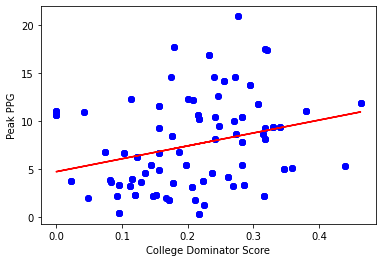

In [9]:
x = df['college_dom']
y = df['peakPPG']
m, b = np.polyfit(x, y, 1)
best_fit = m * x + b
plt.scatter(x,y,color='blue')
plt.plot(x, best_fit, color='red')
plt.xlabel('College Dominator Score')
plt.ylabel('Peak PPG')
plt.show()

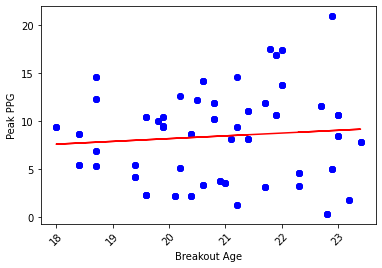

In [10]:
x = df[df['breakout_age'].notna()]['breakout_age']
y = df[df['breakout_age'].notna()]['peakPPG']
m, b = np.polyfit(x, y, 1)
best_fit = m * x + b
plt.scatter(x,y,color='blue')
plt.plot(x, best_fit, color='red')
plt.xticks(rotation=45)
plt.xlabel('Breakout Age')
plt.ylabel('Peak PPG')
plt.show()

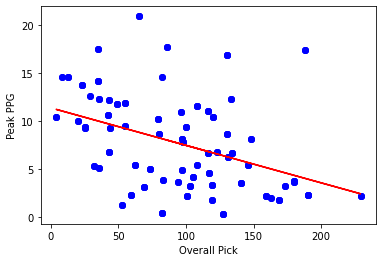

In [11]:
x = df[df['ovr_pick'].notna()]['ovr_pick']
y = df[df['ovr_pick'].notna()]['peakPPG']
m, b = np.polyfit(x, y, 1)
best_fit = m * x + b
plt.scatter(x,y,color='blue')
plt.plot(x, best_fit, color='red')
plt.xlabel('Overall Pick')
plt.ylabel('Peak PPG')
plt.show()

In [12]:
rooks = df[df['year'] > 2018]
df = df[df['year'] <= 2018]

In [25]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
import statistics

In [14]:
X = df.drop(columns=['peakPPG','draft','age.1', 'name'])
y = df['peakPPG']
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, 
    test_size=.2, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, 
    test_size=.5, random_state=0)

In [15]:
X_valid

,year,games,rec,yds,tgtsh,ctr,tds,st,age,school,college_dom,college_tgts,breakout_age,40,speed,burst,agility,catch,ovr_pick
1,2014,3,1,25,<NA>,<NA>,0,0,21,Iowa,0.232,0.143,21.9,4.52,117.7,127.3,10.83,10.35,130.0
0,2013,3,5,108,<NA>,<NA>,0,0,20,Iowa,0.232,0.143,21.9,4.52,117.7,127.3,10.83,10.35,130.0
1,2014,2,4,65,<NA>,<NA>,2,0,20,Toledo,0.237,0.118,22.3,4.86,96.3,107.5,11.56,9.82,117.0
0,2017,6,10,97,<NA>,<NA>,4,0,18,Stanford,0.187,0.110,18.7,4.77,100.7,111.4,11.61,10.04,123.0
0,2017,10,24,320,<NA>,<NA>,3,0,20,Iowa,0.240,0.155,21.2,4.70,103.7,127.1,11.20,10.27,8.0
2,2016,13,92,1293,<NA>,<NA>,11,0,21,South Dakota State,0.307,0.147,21.7,4.69,106.7,121.8,11.33,10.16,49.0
2,2017,8,35,504,<NA>,<NA>,5,0,22,Central Michigan,0.241,0.139,21.1,4.80,93.9,126.5,11.36,10.17,148.0
2,2014,5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,24,BYU,0.000,0.000,23.0,4.51,103.5,128.4,11.40,10.16,NaN
1,2016,12,23,222,<NA>,<NA>,1,0,20,Stanford,0.114,0.096,NaN,4.75,96.6,116.0,11.40,9.97,133.0
0,2016,6,9,70,<NA>,<NA>,1,0,18,Iowa,0.270,0.149,19.8,4.50,120.8,132.6,11.03,10.45,20.0


In [16]:
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dvalid = xgb.DMatrix(X_valid, label=y_valid, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'eta': 0.1,
    'eval_metric': 'rmse'
}
num_round = 100
bst = xgb.train(params, dtrain, num_round)
y_pred = bst.predict(dvalid)
mse = mean_squared_error(y_valid, y_pred)
print(f'Mean squared error: {mse}')

Mean squared error: 3.375470744924662


In [17]:
sum(abs(bst.predict(dtest) - y_test) < 0.5) / len(y_test)

0.4

In [18]:
sum(abs(bst.predict(dtest) - y_test) < 1) / len(y_test)

0.5333333333333333

In [19]:
sum(abs(bst.predict(dtest) - y_test) < 2) / len(y_test)

0.6666666666666666

In [20]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
xgb.plot_importance(model)
plt.show()

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:school: category

In [ ]:
x = df[df['games'].notna()]['games']
y = df[df['games'].notna()]['peakPPG']
plt.scatter(x,y,color='blue')
plt.xlabel('Games Played')
plt.ylabel('Peak PPG')
plt.show()

In [ ]:
X = df.drop(columns=['peakPPG','draft','age.1', 'name', 'school', 'year','games'])
y = df['peakPPG']
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, 
    test_size=.2, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, 
    test_size=.5, random_state=0)

In [ ]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
xgb.plot_importance(model)
plt.show()

In [ ]:
sum(abs(model.predict(X_test) - y_test.values) < 0.5) / len(X_test)

In [ ]:
sum(abs(model.predict(X_test) - y_test.values) < 1) / len(X_test)

In [ ]:
sum(abs(model.predict(X_test) - y_test.values) < 2) / len(X_test)

In [22]:
rookie_tes = ['Brock Bowers', 'JaTavion Sanders', 'Theo Johnson',
             'Cade Stover', 'Ben Sinnott', 'Tip Reiman', 'Jared Wiley']
rooks[rooks['name'].isin(rookie_tes)]

,year,games,rec,yds,tgtsh,ctr,tds,st,age,school,...,college_tgts,breakout_age,40,speed,burst,agility,catch,peakPPG,name,ovr_pick
0,2021,15,56,882,0.2,0.691,13,0,18,Georgia,...,0.142,18.7,4.53,113.3,NaN,NaN,NaN,14.6,Brock Bowers,13.0
1,2022,15,63,942,0.161,0.798,7,0,19,Georgia,...,0.142,18.7,4.53,113.3,NaN,NaN,NaN,14.6,Brock Bowers,13.0
2,2023,10,56,713,0.16,0.767,6,0,20,Georgia,...,0.142,18.7,4.53,113.3,NaN,NaN,NaN,14.6,Brock Bowers,13.0
0,2021,1,0,0,<NA>,<NA>,0,-8,18,Texas,...,0.133,NaN,4.69,100.7,NaN,NaN,NaN,4.9,JaTavion Sanders,97.0
1,2022,13,54,613,0.19,0.701,5,0,19,Texas,...,0.133,NaN,4.69,100.7,NaN,NaN,NaN,4.9,JaTavion Sanders,97.0
2,2023,14,45,682,0.146,0.652,2,0,20,Texas,...,0.133,NaN,4.69,100.7,NaN,NaN,NaN,4.9,JaTavion Sanders,97.0
0,2021,12,2,15,<NA>,<NA>,0,0,19,Kansas State,...,0.138,21.2,4.68,103.7,133.0,11.05,10.36,1.2,Ben Sinnott,53.0
1,2022,14,31,447,<NA>,<NA>,4,0,20,Kansas State,...,0.138,21.2,4.68,103.7,133.0,11.05,10.36,1.2,Ben Sinnott,53.0
2,2023,12,49,676,0.179,0.645,6,0,21,Kansas State,...,0.138,21.2,4.68,103.7,133.0,11.05,10.36,1.2,Ben Sinnott,53.0
0,2020,3,4,56,0.023,0.571,0,0,19,Penn State,...,0.138,NaN,4.57,121.2,131.6,11.34,10.41,3.2,Theo Johnson,103.0


In [36]:
for rookie in rookie_tes:
    test = rooks[rooks['name'] == rookie].drop(columns=['peakPPG','draft','age.1', 'name'])
    test = xgb.DMatrix(test, enable_categorical=True)
    agg = bst.predict(test)
    print(rookie + ': ' + 'min: ' + str(min(agg)) + ' mean: ' + str(statistics.mean(agg)) + ' max: ' + str(max(agg)))

Brock Bowers: min: 8.166455 mean: 8.438446 max: 8.824176
JaTavion Sanders: min: 7.581529 mean: 7.914602 max: 8.434664
Theo Johnson: min: 6.201068 mean: 7.192724 max: 7.9159784
Cade Stover: min: 5.3549647 mean: 5.3780837 max: 5.394931
Ben Sinnott: min: 9.988411 mean: 10.590165 max: 11.332031
Tip Reiman: min: 7.366528 mean: 7.895588 max: 8.7581
Jared Wiley: min: 7.874275 mean: 8.417522 max: 8.980121
